<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [5]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
\
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm

In [6]:
from google.colab import files

train_pos_after_eda = files.upload()


Saving train_pos_after_eda.csv to train_pos_after_eda (1).csv


# 1. Reading Data

In [315]:
train_graph=nx.read_edgelist('train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(train_graph))

DiGraph with 25166 nodes and 12952 edges


# 2. Similarity measures

## 2.1 Jaccard Distance:
http://www.statisticshowto.com/jaccard-index/

\begin{equation}
j = \frac{|X\cap Y|}{|X \cup Y|} 
\end{equation}

In [316]:
#for followees
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim

In [317]:
#one test case
print(jaccard_for_followees(273084,1505602))

0.0


In [318]:
#node 1635354 not in graph 
print(jaccard_for_followees(273084,1505602))

0.0


In [319]:
#for followers
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [320]:
print(jaccard_for_followers(273084,470294))

0


In [321]:
#node 1635354 not in graph 
print(jaccard_for_followees(669354,1635354))

0


## 2.2 Cosine distance

\begin{equation}
CosineDistance = \frac{|X\cap Y|}{|X|\cdot|Y|} 
\end{equation}

In [322]:
#for followees
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

In [323]:
print(cosine_for_followees(273084,1505602))

0


In [324]:
print(cosine_for_followees(273084,1635354))

0


In [325]:
def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [326]:
print(cosine_for_followers(2,470294))

0


In [327]:
print(cosine_for_followers(669354,1635354))

0


## 3. Ranking Measures

https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html

PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links.

<img src='PageRanks-Example.jpg'/>

Mathematical PageRanks for a simple network, expressed as percentages. (Google uses a logarithmic scale.) Page C has a higher PageRank than Page E, even though there are fewer links to C; the one link to C comes from an important page and hence is of high value. If web surfers who start on a random page have an 85% likelihood of choosing a random link from the page they are currently visiting, and a 15% likelihood of jumping to a page chosen at random from the entire web, they will reach Page E 8.1% of the time. <b>(The 15% likelihood of jumping to an arbitrary page corresponds to a damping factor of 85%.) Without damping, all web surfers would eventually end up on Pages A, B, or C, and all other pages would have PageRank zero. In the presence of damping, Page A effectively links to all pages in the web, even though it has no outgoing links of its own.</b>

## 3.1 Page Ranking

https://en.wikipedia.org/wiki/PageRank


In [328]:
pr = nx.pagerank(train_graph, alpha=0.85)
print('min',pr[min(pr, key=pr.get)])
print('max',pr[max(pr, key=pr.get)])
print('mean',float(sum(pr.values())) / len(pr))
#for imputing to nodes which are not there in Train data
mean_pr = float(sum(pr.values())) / len(pr)
print(mean_pr)

min 2.7450623672511845e-05
max 0.00011819029018120126
mean 3.973615195104269e-05
3.973615195104269e-05


# 4. Other Graph Features

## 4.1 Shortest path:

Getting Shortest path between twoo nodes, if nodes have direct path i.e directly connected then we are removing that edge and calculating path. 

In [329]:
#if has direct edge then deleting that edge and calculating shortest path
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        return -1

In [330]:
#testing
compute_shortest_path_length(77697, 826021)

-1

In [331]:
#testing
compute_shortest_path_length(669354,1635354)

-1

## 4.2 Checking for same community

In [332]:
#getting weekly connected edges from graph 
wcc=list(nx.weakly_connected_components(train_graph))
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

In [333]:
belongs_to_same_wcc(861, 1659750)

0

In [334]:
belongs_to_same_wcc(669354,1635354)

0

## 4.3 Adamic/Adar Index:
Adamic/Adar measures is defined as inverted sum of degrees of common neighbours for given two vertices.
$$A(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{log(|N(u)|)}$$

In [335]:
#adar index
def calc_adar_in(a,b):
    sum=0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

In [336]:
calc_adar_in(1,189226)

0

In [337]:
calc_adar_in(669354,1635354)

0

## 4.4 Is persion was following back:

In [338]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

In [339]:
follows_back(1,189226)

0

In [340]:
follows_back(669354,1635354)

0

## 4.5 Katz Centrality:
https://en.wikipedia.org/wiki/Katz_centrality

https://www.geeksforgeeks.org/katz-centrality-centrality-measure/
 Katz centrality computes the centrality for a node 
    based on the centrality of its neighbors. It is a 
    generalization of the eigenvector centrality. The
    Katz centrality for node `i` is
 
$$x_i = \alpha \sum_{j} A_{ij} x_j + \beta,$$
where `A` is the adjacency matrix of the graph G 
with eigenvalues $$\lambda$$.

The parameter $$\beta$$ controls the initial centrality and 

$$\alpha < \frac{1}{\lambda_{max}}.$$

In [341]:

#katz = pickle.load(open('data/fea_sample/katz.p','rb'))


In [342]:
katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)


In [343]:
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean',float(sum(katz.values())) / len(katz))

min 0.006287459137567449
max 0.0064132083203187985
mean 0.006303640900271848


In [344]:
mean_katz = float(sum(katz.values())) / len(katz)
print(mean_katz)

0.006303640900271848


## 4.6 Hits Score
The HITS algorithm computes two numbers for a node. Authorities estimates the node value based on the incoming links. Hubs estimates the node value based on outgoing links.

https://en.wikipedia.org/wiki/HITS_algorithm

In [345]:
 hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)

In [346]:
print('min',hits[0][min(hits[0], key=hits[0].get)])
print('max',hits[0][max(hits[0], key=hits[0].get)])
print('mean',float(sum(hits[0].values())) / len(hits[0]))

min -3.0046539520815165e-15
max 1.000000000000008
mean 3.9736151951045076e-05


# 5. Featurization

## 5. 1 Reading a sample of Data from both train and test

In [347]:
! gdown --id 1lcxzVZ0-MkPmoH3lS35Q8rRfrecKSXb1
! gdown --id 1_KN7S8zfHdrkRjRYOEtBxBVq8JrGxPXD

Downloading...
From: https://drive.google.com/uc?id=1lcxzVZ0-MkPmoH3lS35Q8rRfrecKSXb1
To: /content/train_after_eda.csv
100% 239M/239M [00:02<00:00, 91.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_KN7S8zfHdrkRjRYOEtBxBVq8JrGxPXD
To: /content/test_after_eda.csv
100% 59.7M/59.7M [00:00<00:00, 77.8MB/s]


In [348]:
import random
if os.path.isfile('train_after_eda.csv'):
    filename = "train_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 15100030
    # n_train = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_train =  15100028
    s = 100000 #desired sample size
    skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))
    #https://stackoverflow.com/a/22259008/4084039

In [349]:
if os.path.isfile('train_after_eda.csv'):
    filename = "test_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 3775008
    # n_test = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_test = 3775006
    s = 50000 #desired sample size
    skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))
    #https://stackoverflow.com/a/22259008/4084039


In [350]:
print("Number of rows in the train data file:", n_train)
print("Number of rows we are going to elimiate in train data are",len(skip_train))
print("Number of rows in the test data file:", n_test)
print("Number of rows we are going to elimiate in test data are",len(skip_test))

Number of rows in the train data file: 15100028
Number of rows we are going to elimiate in train data are 15000028
Number of rows in the test data file: 3775006
Number of rows we are going to elimiate in test data are 3725006


In [351]:
#https://drive.google.com/file/d/19mviN_yeJIfakb4kU5NfKdQlOQtaQ-kH/view?usp=sharing
!gdown --id 19mviN_yeJIfakb4kU5NfKdQlOQtaQ-kH

Downloading...
From: https://drive.google.com/uc?id=19mviN_yeJIfakb4kU5NfKdQlOQtaQ-kH
To: /content/train_y.csv
100% 45.3M/45.3M [00:00<00:00, 170MB/s]


In [352]:
#https://drive.google.com/file/d/1H6qybuXr8i_USWu3k3ulXEOurc-SElUh/view?usp=sharing
!gdown --id 1H6qybuXr8i_USWu3k3ulXEOurc-SElUh

Downloading...
From: https://drive.google.com/uc?id=1H6qybuXr8i_USWu3k3ulXEOurc-SElUh
To: /content/test_y.csv
100% 11.3M/11.3M [00:00<00:00, 68.1MB/s]


In [353]:
df_final_train = pd.read_csv('train_after_eda.csv', skiprows=skip_train, names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('train_y.csv', skiprows=skip_train, names=['indicator_link'])
print("Our train matrix size ",df_final_train.shape)
df_final_train.head(2)

Our train matrix size  (100002, 3)


,source_node,destination_node,indicator_link
0,273084,1505602,1
1,1580187,612293,1


In [354]:
df_final_test = pd.read_csv('test_after_eda.csv', skiprows=skip_train, names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('test_y.csv', skiprows=skip_train, names=['indicator_link'])
print("Our train matrix size ",df_final_test.shape)
df_final_test.head(2)

Our train matrix size  (24943, 3)


,source_node,destination_node,indicator_link
0,848424,784690,1
1,1591784,635851,1


## 5.2 Adding a set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>jaccard_followers</li>
<li>jaccard_followees</li>
<li>cosine_followers</li>
<li>cosine_followees</li>
<li>num_followers_s</li>
<li>num_followees_s</li>
<li>num_followers_d</li>
<li>num_followees_d</li>
<li>inter_followers</li>
<li>inter_followees</li>
</ol>

In [355]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

In [356]:
df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)
    
df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)


In [357]:
df_final_train.head()


,source_node,destination_node,indicator_link,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees
0,273084,1505602,1,0,1,2,0,0,0
1,1580187,612293,1,0,1,1,0,0,0
2,1344467,917597,1,0,1,1,0,0,0
3,1064981,1433369,1,0,1,1,0,0,0
4,1806137,474413,1,0,1,1,0,0,0


In [361]:
# ! gdown --id 1fDJptlCFEWNV5UNGPc4geTykgFI3PDCV

In [362]:
# df_final_train = read_hdf('storage_sample_stage4.h5', 'train_df',mode='r')
# df_final_test = read_hdf('storage_sample_stage4.h5', 'test_df',mode='r')

In [363]:
# df_final_train.tail()

In [364]:
# df_final_train_new=df_final_train.drop(['num_followers_s',	'num_followees_s',	'num_followees_d'	,'inter_followers',	'inter_followees'],axis=1)

In [365]:
# df_final_train['num_followers_d']= compute_features_stage1(df_final_train)

In [366]:
# df_final_train.tail()

In [367]:
# for val in df_final_train_new['num_followers_s'].values:
#   if(val>0):
#     print(val)

In [368]:
# https://drive.google.com/file/d/10qJ04GRcaDxc16gmJXb8rpGPmlyys7E2/view?usp=sharing
! gdown --id 10qJ04GRcaDxc16gmJXb8rpGPmlyys7E2

Downloading...
From: https://drive.google.com/uc?id=10qJ04GRcaDxc16gmJXb8rpGPmlyys7E2
To: /content/storage_sample_stage2.h5
100% 22.9M/22.9M [00:00<00:00, 86.8MB/s]



## 5.3 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>adar index</li>
<li>is following back</li>
<li>belongs to same weakly connect components</li>
<li>shortest path between source and destination</li>
</ol>

In [369]:

    #mapping adar index on train
df_final_train['adar_index'] = df_final_train.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)
    #mapping adar index on test
df_final_test['adar_index'] = df_final_test.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping followback or not on train
df_final_train['follows_back'] = df_final_train.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #mapping followback or not on test
df_final_test['follows_back'] = df_final_test.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping same component of wcc or not on train
df_final_train['same_comp'] = df_final_train.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

    ##mapping same component of wcc or not on train
df_final_test['same_comp'] = df_final_test.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)
    
    #--------------------------------------------------------------------------------------------------------
    #mapping shortest path on train 
df_final_train['shortest_path'] = df_final_train.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
    #mapping shortest path on test
df_final_test['shortest_path'] = df_final_test.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)



df_final_train.head(2)
df_final_test.head(2)

## 5.4 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>Weight Features
    <ul>
        <li>weight of incoming edges</li>
        <li>weight of outgoing edges</li>
        <li>weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges * weight of outgoing edges</li>
        <li>2*weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges + 2*weight of outgoing edges</li>
    </ul>
</li>
<li>Page Ranking of source</li>
<li>Page Ranking of dest</li>
<li>katz of source</li>
<li>katz of dest</li>
<li>hubs of source</li>
<li>hubs of dest</li>
<li>authorities_s of source</li>
<li>authorities_s of dest</li>
</ol>

#### Weight Features

In order to determine the similarity of nodes, an edge weight value was calculated between nodes. Edge weight decreases as the neighbor count goes up. Intuitively, consider one million people following a celebrity on a social network then chances are most of them never met each other or the celebrity. On the other hand, if a user has 30 contacts in his/her social network, the chances are higher that many of them know each other. 
`credit` - Graph-based Features for Supervised Link Prediction
William Cukierski, Benjamin Hamner, Bo Yang

\begin{equation}
W = \frac{1}{\sqrt{1+|X|}}
\end{equation}

it is directed graph so calculated Weighted in and Weighted out differently

In [370]:
#weight for source and destination of each link
Weight_in = {}
Weight_out = {}
for i in  tqdm(train_graph.nodes()):
    s1=set(train_graph.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i]=w_in
    
    s2=set(train_graph.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i]=w_out
    
#for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

100%|██████████| 25166/25166 [00:00<00:00, 154539.01it/s]


In [371]:

    #mapping to pandas train
df_final_train['weight_in'] = df_final_train.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
df_final_train['weight_out'] = df_final_train.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))

    #mapping to pandas test
df_final_test['weight_in'] = df_final_test.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
df_final_test['weight_out'] = df_final_test.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))


    #some features engineerings on the in and out weights
df_final_train['weight_f1'] = df_final_train.weight_in + df_final_train.weight_out
df_final_train['weight_f2'] = df_final_train.weight_in * df_final_train.weight_out
df_final_train['weight_f3'] = (2*df_final_train.weight_in + 1*df_final_train.weight_out)
df_final_train['weight_f4'] = (1*df_final_train.weight_in + 2*df_final_train.weight_out)

    #some features engineerings on the in and out weights
df_final_test['weight_f1'] = df_final_test.weight_in + df_final_test.weight_out
df_final_test['weight_f2'] = df_final_test.weight_in * df_final_test.weight_out
df_final_test['weight_f3'] = (2*df_final_test.weight_in + 1*df_final_test.weight_out)
df_final_test['weight_f4'] = (1*df_final_test.weight_in + 2*df_final_test.weight_out)

In [372]:

    
    #page rank for source and destination in Train and Test
    #if anything not there in train graph then adding mean page rank 
df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x:pr.get(x,mean_pr))
df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x:pr.get(x,mean_pr))

df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x:pr.get(x,mean_pr))
df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x:pr.get(x,mean_pr))
    #================================================================================

    #Katz centrality score for source and destination in Train and test
    #if anything not there in train graph then adding mean katz score
df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x: katz.get(x,mean_katz))
df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x: katz.get(x,mean_katz))

df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x: katz.get(x,mean_katz))
df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x: katz.get(x,mean_katz))
    #================================================================================

    #Hits algorithm score for source and destination in Train and test
    #if anything not there in train graph then adding 0
df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x: hits[0].get(x,0))
df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x: hits[0].get(x,0))

df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x: hits[0].get(x,0))
df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x: hits[0].get(x,0))
    #================================================================================

    #Hits algorithm score for source and destination in Train and Test
    #if anything not there in train graph then adding 0
df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x: hits[1].get(x,0))
df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x: hits[1].get(x,0))

df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x: hits[1].get(x,0))
df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x: hits[1].get(x,0))
    #================================================================================



## 5.5 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>SVD features for both source and destination</li>
</ol>

In [373]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [374]:
#for svd features to get feature vector creating a dict node val and inedx in svd vector
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [375]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

In [376]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (25166, 25166)
U Shape (25166, 6)
V Shape (6, 25166)
s Shape (6,)


In [377]:

df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
df_final_train.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
df_final_train.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    #===================================================================================================
    
df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
df_final_train.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
df_final_train.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================
    
df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
df_final_test.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
df_final_test.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

    #===================================================================================================
    
df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
df_final_test.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
df_final_test.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================

   

In [378]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link', 'num_followers_s',
       'num_followers_d', 'num_followees_s', 'num_followees_d',
       'inter_followers', 'inter_followees', 'adar_index', 'follows_back',
       'same_comp', 'shortest_path', 'weight_in', 'weight_out', 'weight_f1',
       'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d',
       'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [379]:
# adding pref score
#def pref(a,b):
    #pref_score=[]
    #num_of_follwere_source=np.array(a)
    #num_of_follwere_destination=np.array(b)
    #for i in range(len(num_of_follwere_source)):
        #pref_score.append(num_of_follwere_source[i]*num_of_follwere_destination[i])
    #return pref_score
    

In [380]:
#for train data
#followeres
#df_final_train['prefer_Attach_followers']= df_final_train.apply(lambda x : pref(df_final_train['num_followers_s'],
                                            #df_final_train['num_followers_d']),axis=1)
#for train data
#followees
#df_final_train['prefer_Attach_followers']= df_final_train.apply(lambda x : pref(df_final_train['num_followees_s'],
                                            #df_final_train['num_followees_d']),axis=1)
                                                                

In [381]:
import numpy as np

#for train dataset
followers_source=np.array(df_final_train['num_followees_s'])
followers_destination =np.array(df_final_train['num_followees_d'])
preferential_followers=[]
for i in range(len(followers_source)):
    preferential_followers.append(followers_source[i]*followers_destination[i])
df_final_train['prefer_Attach_score_followers']= preferential_followers


#train folowees
followees_source      =np.array(df_final_train['num_followees_s'])
followees_destination =np.array(df_final_train['num_followees_d'])
preferential_followees=[]
for i in range(len(followers_source)):
    preferential_followees.append(followees_source[i]*followees_destination[i])
df_final_train['prefer_Attach_score_followees']= preferential_followees
                                                                


In [382]:
#for test dataset
followers_source =np.array(df_final_test['num_followees_s'])
followers_destination=np.array(df_final_test['num_followees_d'])
preferential_followers=[]
for i in range(len(followers_source)):
    preferential_followers.append(followers_source[i]*followers_destination[i])
df_final_test['prefer_Attach_score_followers']= preferential_followers


#for test dataset
followers_source=np.array(df_final_test['num_followees_s'])
followers_destination=np.array(df_final_test['num_followees_d'])
preferential_followees=[]
for i in range(len(followers_source)):
    preferential_followees.append(followers_source[i]*followers_destination[i])
df_final_test['prefer_Attach_score_followees']= preferential_followees


In [383]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link', 'num_followers_s',
       'num_followers_d', 'num_followees_s', 'num_followees_d',
       'inter_followers', 'inter_followees', 'adar_index', 'follows_back',
       'same_comp', 'shortest_path', 'weight_in', 'weight_out', 'weight_f1',
       'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d',
       'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'prefer_Attach_score_followers', 'prefer_Attach_score_followees'],
      dtype='object')

In [384]:
df_final_test.columns

Index(['source_node', 'destination_node', 'indicator_link', 'num_followers_s',
       'num_followers_d', 'num_followees_s', 'num_followees_d',
       'inter_followers', 'inter_followees', 'adar_index', 'follows_back',
       'same_comp', 'shortest_path', 'weight_in', 'weight_out', 'weight_f1',
       'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d',
       'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'prefer_Attach_score_followers', 'prefer_Attach_score_followees'],
      dtype='object')

In [385]:
df_final_test.head(2)

,source_node,destination_node,indicator_link,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,prefer_Attach_score_followers,prefer_Attach_score_followees
0,848424,784690,1,0,0,0,0,0,0,0,0,0,-1,0.851471,0.851652,1.703123,0.725157,2.554595,2.554775,0.00004,0.00004,0.006304,0.006304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,1591784,635851,1,0,0,0,0,0,0,0,0,0,-1,0.851471,0.851652,1.703123,0.725157,2.554595,2.554775,0.00004,0.00004,0.006304,0.006304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [386]:
df_final_train.head(2)

,source_node,destination_node,indicator_link,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,prefer_Attach_score_followers,prefer_Attach_score_followees
0,273084,1505602,1,0,1,2,0,0,0,0,0,0,-1,1.0,0.707107,1.707107,0.707107,2.707107,2.414214,0.000027,0.000039,0.006287,0.006319,-3.066481e-18,-0.0,-0.0,-1.533240e-18,3.582299e-18,-1.925515e-18,2.095677e-19,1.893078e-18,-3.748049e-18,4.908464e-18,-4.251037e-19,-3.259236e-19,-3.733572e-19,1.063924e-19,2.137828e-19,-1.914925e-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,1580187,612293,1,0,1,1,0,0,0,0,0,0,-1,1.0,1.000000,2.000000,1.000000,3.000000,3.000000,0.000027,0.000051,0.006287,0.006319,1.381718e-20,-0.0,-0.0,1.381718e-20,-1.414303e-18,-9.772021e-19,-9.944478e-19,3.369688e-19,8.573449e-19,-5.686533e-19,2.873803e-19,2.405803e-19,2.699158e-19,-5.607101e-20,-1.843954e-19,1.299550e-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [387]:
# svd dot features

In [388]:
def dot_prod(source1,source2,source3,source4,source5,source6,source7,source8,source9,source10,source11,source12,\
             destination1,destination2,destination3,destination4,destination5,destination6,destination7,destination8,\
             destination9,destination10,destination11,destination12):
  svd_dot=[]
  for i in range(len(np.array(source1))):
    a=[]
    b=[]
    
    a.append(np.array(source1[i]))
    a.append(np.array(source2[i]))
    a.append(np.array(source3[i]))
    a.append(np.array(source4[i]))
    a.append(np.array(source5[i]))
    a.append(np.array(source6[i]))
    a.append(np.array(source7[i]))
    a.append(np.array(source8[i]))
    a.append(np.array(source9[i]))
    a.append(np.array(source10[i]))
    a.append(np.array(source11[i]))
    a.append(np.array(source12[i]))
    b.append(np.array(destination1[i]))
    b.append(np.array(destination2[i]))
    b.append(np.array(destination3[i]))
    b.append(np.array(destination4[i]))
    b.append(np.array(destination5[i]))
    b.append(np.array(destination6[i]))
    b.append(np.array(destination7[i]))
    b.append(np.array(destination8[i]))
    b.append(np.array(destination9[i]))
    b.append(np.array(destination10[i]))
    b.append(np.array(destination11[i]))
    b.append(np.array(destination12[i]))
    svd_dot.append(np.dot(a,b))
  return svd_dot
      

In [389]:
source_1,source_2,source_3,source_4,source_5,source_6=df_final_train['svd_u_s_1'],df_final_train['svd_u_s_2'],df_final_train['svd_u_s_3'],df_final_train['svd_u_s_4'],\
                                              df_final_train['svd_u_s_5'],df_final_train['svd_u_s_6']
source_7,source_8,source_9,source_10,source_11,source_12=df_final_train['svd_v_s_1'],df_final_train['svd_v_s_2'],df_final_train['svd_v_s_3'],df_final_train['svd_v_s_4'],\
                                              df_final_train['svd_v_s_5'],df_final_train['svd_v_s_6']

destination_1,destination_2,destination_3,destination_4,destination_5,destination_6=df_final_train['svd_u_d_1'],df_final_train['svd_u_d_2'],df_final_train['svd_u_d_3'],\
                                                                              df_final_train['svd_u_d_4'],df_final_train['svd_u_d_5'],df_final_train['svd_u_d_6']
destination_7,destination_8,destination_9,destination_10,destination_11,destination_12=df_final_train['svd_v_d_1'],df_final_train['svd_v_d_2'],df_final_train['svd_v_d_3'],\
                                                                              df_final_train['svd_v_d_4'],df_final_train['svd_v_d_5'],df_final_train['svd_v_d_6']

df_final_train['svd_dot']=dot_prod(source_1,source_2,source_3,source_4,source_5,source_6,source_7,source_8,source_9,source_10,source_11,source_12,\
             destination_1,destination_2,destination_3,destination_4,destination_5,destination_6,destination_7,destination_8,\
             destination_9,destination_10,destination_11,destination_12)


In [390]:
#test data
source_1,source_2,source_3,source_4,source_5,source_6=df_final_test['svd_u_s_1'],df_final_test['svd_u_s_2'],df_final_test['svd_u_s_3'],df_final_test['svd_u_s_4'],\
                                              df_final_test['svd_u_s_5'],df_final_test['svd_u_s_6']
source_7,source_8,source_9,source_10,source_11,source_12=df_final_test['svd_v_s_1'],df_final_test['svd_v_s_2'],df_final_test['svd_v_s_3'],df_final_test['svd_v_s_4'],\
                                              df_final_test['svd_v_s_5'],df_final_test['svd_v_s_6']
#destination
destination_1,destination_2,destination_3,destination_4,destination_5,destination_6=df_final_test['svd_u_d_1'],df_final_test['svd_u_d_2'],df_final_test['svd_u_d_3'],\
                                                                              df_final_test['svd_u_d_4'],df_final_test['svd_u_d_5'],df_final_test['svd_u_d_6']
destination_7,destination_8,destination_9,destination_10,destination_11,destination_12=df_final_test['svd_v_d_1'],df_final_test['svd_v_d_2'],df_final_test['svd_v_d_3'],\
                                                                              df_final_test['svd_v_d_4'],df_final_test['svd_v_d_5'],df_final_test['svd_v_d_6']




In [391]:
df_final_test['svd_dot']=dot_prod(source_1,source_2,source_3,source_4,source_5,source_6,source_7,source_8,source_9,source_10,source_11,source_12,\
             destination_1,destination_2,destination_3,destination_4,destination_5,destination_6,destination_7,destination_8,\
             destination_9,destination_10,destination_11,destination_12)

In [392]:
df_final_train.head(2)

,source_node,destination_node,indicator_link,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,prefer_Attach_score_followers,prefer_Attach_score_followees,svd_dot
0,273084,1505602,1,0,1,2,0,0,0,0,0,0,-1,1.0,0.707107,1.707107,0.707107,2.707107,2.414214,0.000027,0.000039,0.006287,0.006319,-3.066481e-18,-0.0,-0.0,-1.533240e-18,3.582299e-18,-1.925515e-18,2.095677e-19,1.893078e-18,-3.748049e-18,4.908464e-18,-4.251037e-19,-3.259236e-19,-3.733572e-19,1.063924e-19,2.137828e-19,-1.914925e-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,-2.513315e-36
1,1580187,612293,1,0,1,1,0,0,0,0,0,0,-1,1.0,1.000000,2.000000,1.000000,3.000000,3.000000,0.000027,0.000051,0.006287,0.006319,1.381718e-20,-0.0,-0.0,1.381718e-20,-1.414303e-18,-9.772021e-19,-9.944478e-19,3.369688e-19,8.573449e-19,-5.686533e-19,2.873803e-19,2.405803e-19,2.699158e-19,-5.607101e-20,-1.843954e-19,1.299550e-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,-1.160839e-36


In [393]:
df_final_test.head(2)

,source_node,destination_node,indicator_link,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,prefer_Attach_score_followers,prefer_Attach_score_followees,svd_dot
0,848424,784690,1,0,0,0,0,0,0,0,0,0,-1,0.851471,0.851652,1.703123,0.725157,2.554595,2.554775,0.00004,0.00004,0.006304,0.006304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
1,1591784,635851,1,0,0,0,0,0,0,0,0,0,-1,0.851471,0.851652,1.703123,0.725157,2.554595,2.554775,0.00004,0.00004,0.006304,0.006304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0


# **MODELLING**

In [394]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [395]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [396]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

## hyperparameter optimization

In [397]:
xg=xgb.XGBClassifier()

In [398]:
xg.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

**Training a xgboost model with default parameters**

In [399]:
#d_train=xgb.DMatrix(df_final_train,label=y_train)
#d_test=xgb.DMatrix(df_final_test,label=y_test)
#watchlist=[(d_train,'train'),(d_test,'eval')]
#param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
#param = {'max_depth': 2, 'eta': 1}


#xg.train(param,d_train,watchlist)

In [400]:
#y_pred=model.predict(d_train)
#labels=d_train.get_label()
#labels
#print(y_pred)

accuracy and scores of the model

In [401]:
xg=xgb.XGBClassifier()
xg.fit(df_final_train,y_train)

XGBClassifier()

In [436]:
print(np.shape(y_train))
print(np.shape(df_final_train))


(100002,)
(100002, 51)


In [414]:
#checking perormance on training data
print('PERMORMANCE ON TRAIN DATA ')
y_pred_train=xg.predict(df_final_train)
print('accuracy of the basic xgboost model on train data is is =',accuracy_score(y_train,y_pred_train))
print('f1 score of the basic xgboost model on train data is =',f1_score(y_train,y_pred_train))

y_score_train=xg.predict_proba(df_final_train)
auc=roc_auc_score(y_train,y_score_train[:,1])
print('auc score of on the basic xgboost model is =',auc)

print('**'*80)
print('PERMORMANCE ON TEST DATA ')

y_pred_test=xg.predict(df_final_test)
print('accuracy of the basic xgboost model on test data is is =',accuracy_score(y_test,y_pred_test))
print('f1 score of the basic xgboost model on test data is =',f1_score(y_test,y_pred_test))

y_score_test=xg.predict_proba(df_final_test)
auc=roc_auc_score(y_test,y_score_test[:,1])
print('auc score of on the basic xgboost model on test data is =',auc)

PERMORMANCE ON TRAIN DATA 
accuracy of the basic xgboost model on train data is is = 0.5373792524149517
f1 score of the basic xgboost model on train data is = 0.17823329839955948
auc score of on the basic xgboost model is = 0.5377842881812227
****************************************************************************************************************************************************************
PERMORMANCE ON TEST DATA 
accuracy of the basic xgboost model on test data is is = 0.5402317283406166
f1 score of the basic xgboost model on test data is = 0.17246355895511617
auc score of on the basic xgboost model on test data is = 0.5352450329337304


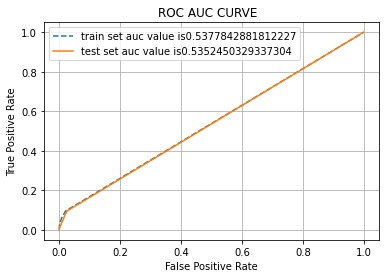

In [415]:
fpr_train,tpr_train,threshold_train=metrics.roc_curve(y_train,y_score_train[:,1])
auc_sc_train=metrics.auc(fpr_train,tpr_train)

fpr_test,tpr_test,threshold_test=metrics.roc_curve(y_test,y_score_test[:,1])
auc_sc_test=metrics.auc(fpr_test,tpr_test)

plt.plot(fpr_train,tpr_train,linestyle='--',label='train set auc value is'+str(auc_sc_train))
plt.plot(fpr_test,tpr_test,linestyle='-',label='test set auc value is'+str(auc_sc_test))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.title('ROC AUC CURVE  ')
plt.show()

FEATURE IMPORTANCE

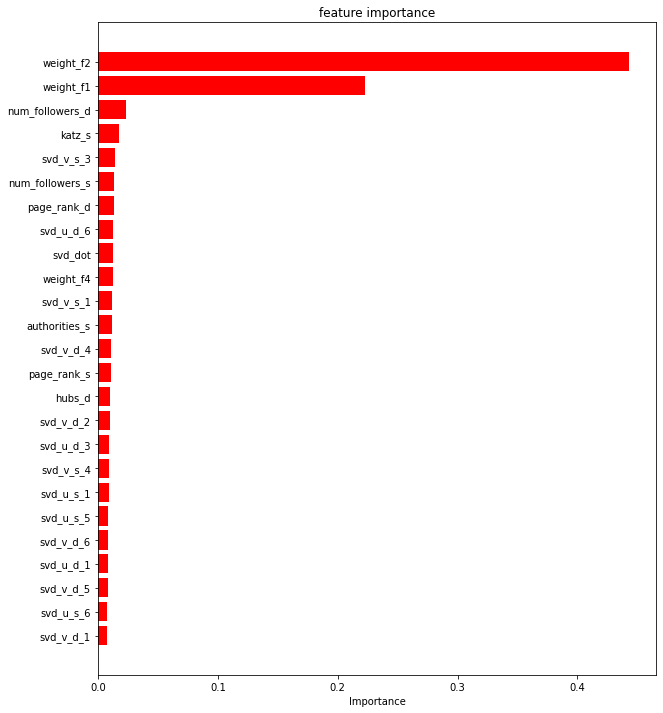

In [416]:
importance=xg.feature_importances_
features=df_final_train.columns
indices=np.argsort(importance)[-25:]
plt.figure(figsize=(10,12))
plt.barh(range(len(indices)),importance[indices],color='r',align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Importance')
plt.title('feature importance')
plt.show()

***HYPERPARAMETER TUNING OF XGBOOST***

In [417]:
from scipy.stats import randint as sp_randint

In [418]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : sp_randint(10,15),
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
 "n_estimators"     :sp_randint(105,125),
 
    
}

In [419]:
clf=RandomizedSearchCV(xg,params,scoring='f1',return_train_score=True,cv=5,n_jobs=-1,verbose=1)
clf.fit(df_final_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=XGBClassifier(), n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd065282390>,
                                        'min_child_weight': [1, 3, 5, 7],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd065282bd0>},
                   return_train_score=True, scoring='f1', verbose=1)

In [420]:
clf.best_params_

{'colsample_bytree': 0.7,
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 7,
 'n_estimators': 109}

In [421]:
clf.best_estimator_

XGBClassifier(colsample_bytree=0.7, gamma=0.1, max_depth=10, min_child_weight=7,
              n_estimators=109)

In [422]:
print('mean train score is = ',clf.cv_results_['mean_train_score'])
print('mean test score is = ',clf.cv_results_['mean_test_score'])

mean train score is =  [0.18052256 0.17934103 0.18145277 0.18030817 0.17854045 0.1798359
 0.17843261 0.17885652 0.17902021 0.18171084]
mean test score is =  [0.16847401 0.17406028 0.1684535  0.16990955 0.17646376 0.1696287
 0.17703333 0.17657624 0.17366362 0.16687744]


using best estimators

In [423]:
tuned_xg=xgb.XGBClassifier(colsample_bytree=0.4, gamma=0.3, learning_rate=0.05, max_depth=14,
              min_child_weight=5, n_estimators=121)

In [424]:
tuned_xg.fit(df_final_train,y_train)

XGBClassifier(colsample_bytree=0.4, gamma=0.3, learning_rate=0.05, max_depth=14,
              min_child_weight=5, n_estimators=121)

In [426]:
#checking perormance on training data
print('PERMORMANCE ON TRAIN DATA ')
y_pred_train=tuned_xg.predict(df_final_train)
print('accuracy of the basic xgboost model on train data is is =',accuracy_score(y_train,y_pred_train))
print('f1 score of the basic xgboost model on train data is =',f1_score(y_train,y_pred_train))

y_score_train=tuned_xg.predict_proba(df_final_train)
auc=roc_auc_score(y_train,y_score_train[:,1])
print('auc score of on the tunes xgboost model is =',auc)

print('**'*80)
print('PERMORMANCE ON TEST DATA ')

y_pred_test=tuned_xg.predict(df_final_test)
print('accuracy of the tuned xgboost model on test data is is =',accuracy_score(y_test,y_pred_test))
print('f1 score of the tuned xgboost model on test data is =',f1_score(y_test,y_pred_test))

y_score_test=tuned_xg.predict_proba(df_final_test)
auc=roc_auc_score(y_test,y_score_test[:,1])
print('auc score of on the tuned xgboost model on test data is =',auc)

PERMORMANCE ON TRAIN DATA 
accuracy of the basic xgboost model on train data is is = 0.5383892322153557
f1 score of the basic xgboost model on train data is = 0.17852439762252198
auc score of on the tunes xgboost model is = 0.5395119612733272
****************************************************************************************************************************************************************
PERMORMANCE ON TEST DATA 
accuracy of the tuned xgboost model on test data is is = 0.5401916369322054
f1 score of the tuned xgboost model on test data is = 0.17185356343418298
auc score of on the tuned xgboost model on test data is = 0.5350324611127347


CONFUSION MATRIX

In [427]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
  
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

### train data confusion matrix

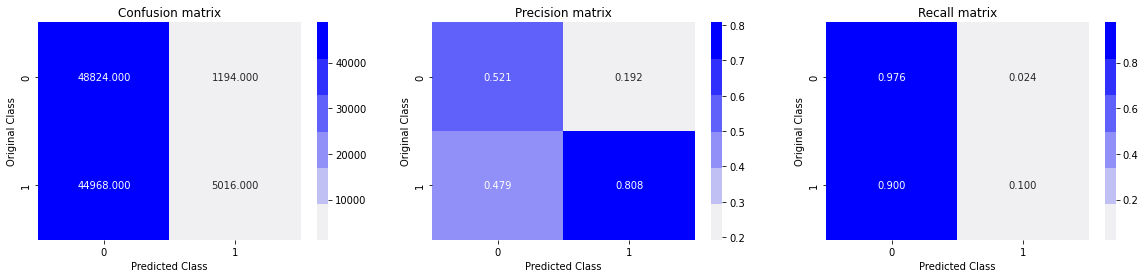

In [428]:
plot_confusion_matrix(y_train,y_pred_train)

###test data confusion matrix

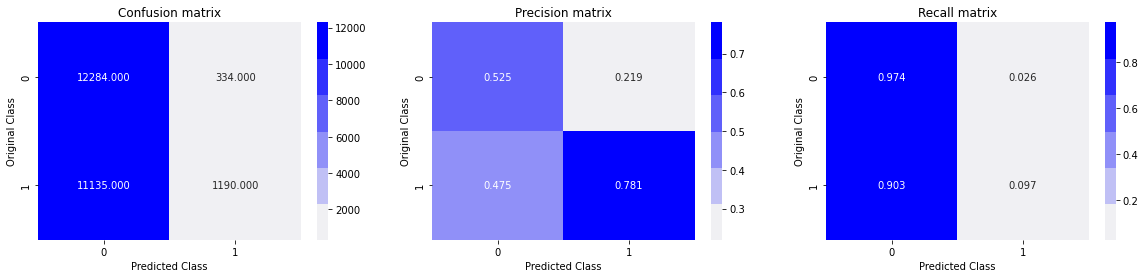

In [429]:
plot_confusion_matrix(y_test,y_pred_test)

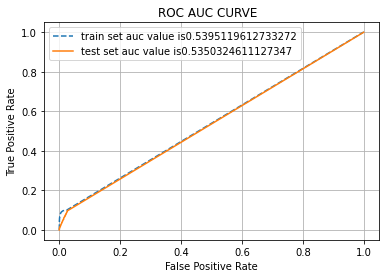

In [430]:
fpr_train,tpr_train,threshold_train=metrics.roc_curve(y_train,y_score_train[:,1])
auc_sc_train=metrics.auc(fpr_train,tpr_train)

fpr_test,tpr_test,threshold_test=metrics.roc_curve(y_test,y_score_test[:,1])
auc_sc_test=metrics.auc(fpr_test,tpr_test)

plt.plot(fpr_train,tpr_train,linestyle='--',label='train set auc value is'+str(auc_sc_train))
plt.plot(fpr_test,tpr_test,linestyle='-',label='test set auc value is'+str(auc_sc_test))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.title('ROC AUC CURVE  ')
plt.show()

FEATURE IMPOTANCE

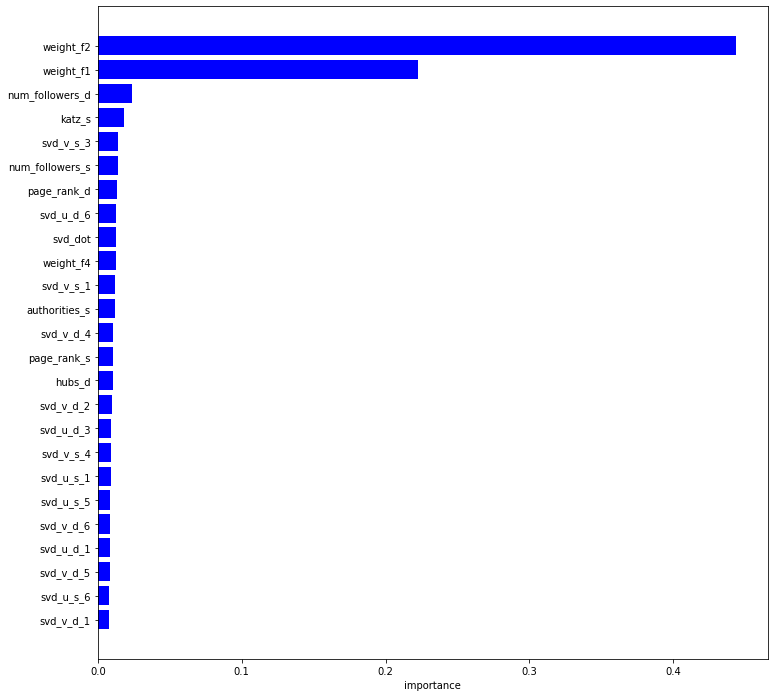

In [431]:
plt.figure(figsize=(12,12))
importance=xg.feature_importances_
features=df_final_test.columns
indices=np.argsort(importance)[-25:]
plt.barh(range(len(indices)),importance[indices],align='center',color='b')
plt.xlabel('importance')
plt.yticks(range(len(indices)),[features[i] for i in indices])
plt.show()

OBSERVATIONS

In [437]:
from prettytable import PrettyTable

In [441]:
table=PrettyTable()

In [442]:
table.field_names=['MODEL','TRAIN F1 SCORE','TEST F1 SCORE','MOST IMPORTANT FEATURE']

In [443]:
table.add_row(['BASEC XG BOOST','0.1782','0.17246','weight_f2'])
table.add_row(['TUNED XG BOOST','0.1785','0.17185','weight_f2'])
print(table)

+----------------+----------------+---------------+------------------------+
|     MODEL      | TRAIN F1 SCORE | TEST F1 SCORE | MOST IMPORTANT FEATURE |
+----------------+----------------+---------------+------------------------+
| BASEC XG BOOST |     0.1782     |    0.17246    |       weight_f2        |
| TUNED XG BOOST |     0.1785     |    0.17185    |       weight_f2        |
+----------------+----------------+---------------+------------------------+


1 first of all we performed exploratory analysis on the features like 
            
            

        1.   No of followers for each person
        2.   No of people each person is following
        3.   both followers + following

2 splittd the data into train and test set(test size 0.2)
3 Performed feature engineering , created new features for both followers and followees for source and destinatinaton differently  like


1.   Jaccard Distance
2.   Cosine distance

1.   Page Ranking
2.   Shortest path

1.   Checking for same community

1.   Adamic/Adar Index

1.   Is person was following back
2.   Katz Centrality


9.   Hits Score


10.  Weight Features


    *   weight of incoming edges
    *   weight of outgoing edges

    *   weight of incoming edges + weight of outgoing edges
    *   weight of incoming edges * weight of outgoing edges

    *   2weight of incoming edges + weight of outgoing edges
    *   weight of incoming edges + 2weight of outgoing edges


11  SVD features (with k=6)

3 TRAINED MODEL ON THE DATA


    *   defined  x_train and y_train
    *   trained xgboost on x_train and predicted y value for the training st and the test set

    *   caclulated f1 score,accuracy,auc score of the model on train and test set
    * plotted the bar graph with 25 most important features

4 Tuned the hyperparameters using RandonSearchCV

    *   got best estimators
5 used the best estimators for the xgboost classifier


    *   caclulated f1 score,accuracy,auc score of the model on train and test set


    *   plotted the roc auc curve for train and test data
    *   plotted the confusion matrix for train and test data
    * plotted the bar graph with 25 most important features

6 created a table with al the information 







































